In [1]:
#Loads modules
import torch as t
import matplotlib.pyplot as plt

import os

import sys
dir_path = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(dir_path,'scripts'))

import json

import importlib
import Systems as Systems
import Plotting as Plotting
import Training as Training
import Controls as Controls
import Evolvers as Evolvers

In [1314]:
experiment = "Flensmon2D_2"

In [1372]:
#Loads the params_dict for the experiment
exp_path = os.path.join(dir_path,"Experiments",experiment)

params_filepath = os.path.join(exp_path,"Parameters.json")
with open(params_filepath) as json_file:
    params_dict = json.load(json_file)

params_dict.update({"exp_path":exp_path})

I added a factor half to the cosines
Loaded UE0s


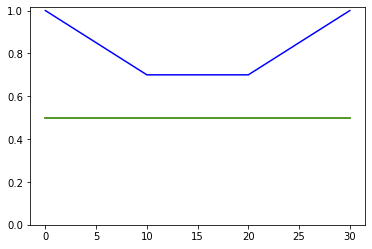

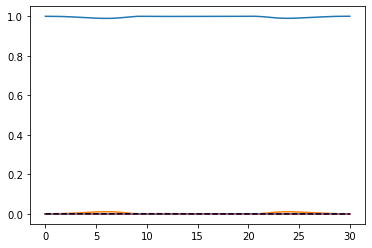

In [1373]:
importlib.reload(Systems)
importlib.reload(Plotting)
importlib.reload(Training)
importlib.reload(Controls)
importlib.reload(Evolvers)

class Flensmon_1D(t.nn.Module, Systems.Periodic_System, Controls.ConstrainedPulse, Evolvers.ETrotter, Training.Trainer, Plotting.Plotter):
    def __init__(self,params_dict):
        super().__init__()
        self.params_dict = params_dict
        super(t.nn.Module,self).__init__()
        return
    
    def forward(self):
        H = self.get_H(self.activation_func(self.times),self.get_control())
        self.latest_matrix_exp = t.matrix_exp(-1j*H*self.dt)
        # self.latest_matrix_exp = self.basis_change@t.matrix_exp(-1j*H*self.dt)
        return t.linalg.multi_dot(list(mat for mat in self.latest_matrix_exp.flip(0)))

    def V_1d(self, alphas, control):
        return self.EJ*(-2*self.cos_mat.repeat((alphas.shape[0],1,1)) \
                            + alphas.view(-1,1,1)*self.cos2_mat \
                            + control.view(-1,1,1)*self.q_mat)
    
    def V_2d(self, alphas, control):
        return self.EJ*(-self.cos_mat.repeat((alphas.shape[0],1,1)) \
                            - alphas.view(-1,1,1)*self.cos2_mat \
                            + control.view(-1,1,1)*self.q_mat)

obj = Flensmon_1D(params_dict)
# obj.plot_potential()
obj.plot_activation_func()
obj.plot_occupancy(indices=[_ for _ in range(5)])

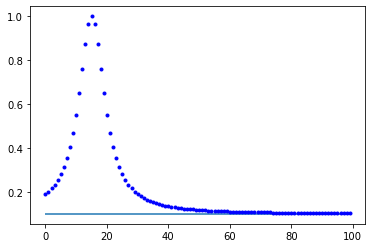

In [1365]:
# def f(epochs):
#     return t.max(0.005*t.ones(epochs.shape),(epochs-4)/(300 + (epochs-4))*(0.1+1/(1+((epochs-100)/100)**2)))

def f(epochs):
    return 0.9/(1+((epochs-15)/5)**2) + 0.1
    # return t.max(0.005*t.ones(epochs.shape),1*(epochs-4)/(300 + (epochs-4)))

epochs = t.arange(0,100,1)
plt.plot(f(epochs),'b.')
plt.hlines(0.1,epochs.min(),epochs.max())

In [1419]:
obj.minimize(0.001,200)

initial loss: 0.01829695701599121
Ended at step: 1463, with loss: 0.01241225004196167 and runtime: 597.7784729003906


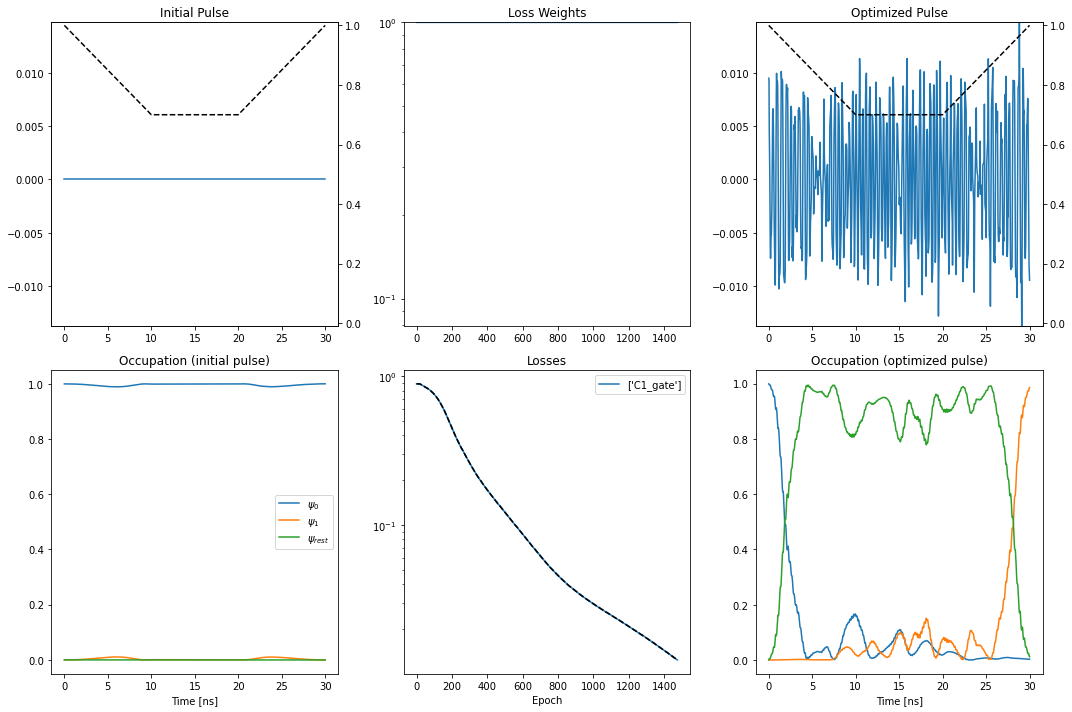

In [1420]:
obj.plot_run(save=False,fig_name="ConstrainedPulse_XGate_0toPulse.pdf")

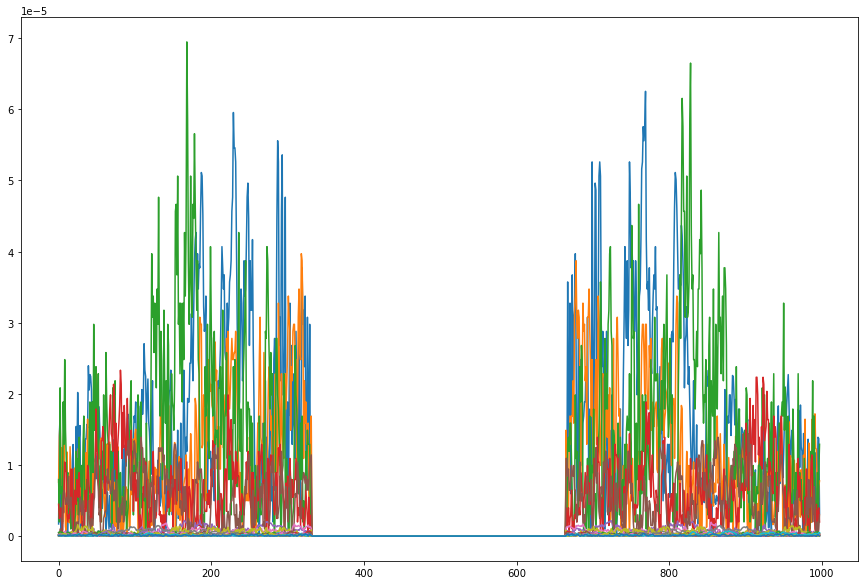

In [1293]:
U0s = obj.U0s
U0dot = 1/(2*obj.dt)*(U0s[2:].adjoint()@U0s[1:-1] - U0s[1:-1].adjoint()@U0s[2:])
plt.figure(figsize=(15,10))
plt.plot(U0dot[:,[_ for _ in range(21)],[_ for _ in range(21)]].abs());

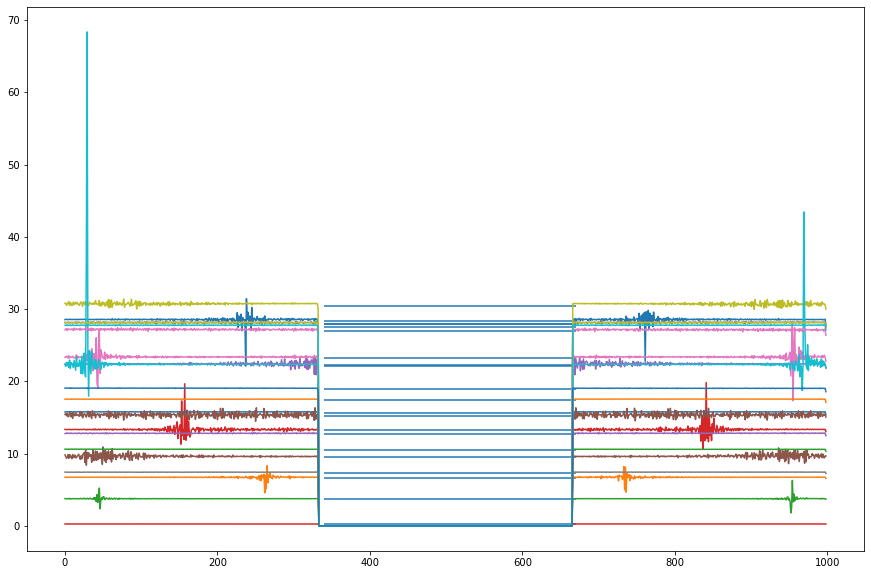

In [1313]:
U0s = obj.U0s
U0dot = 1/(2*obj.dt)*(U0s[1:].adjoint()@U0s[:-1] - U0s[:-1].adjoint()@U0s[1:])
Es = obj.E0s[::41]
tmp = Es[1:] - Es[:-1]
tmp[tmp == 0] = 1
plt.figure(figsize=(15,10))
plt.plot(U0dot[:,[_ for _ in range(21)],[_ for _ in range(21)]].imag/tmp);
plt.hlines(obj.rands*33,340,670)

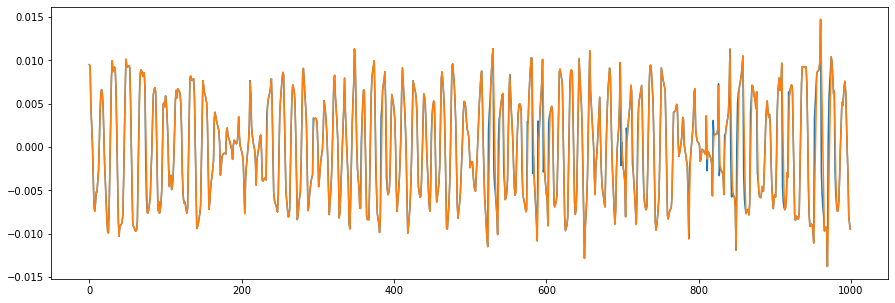

In [1421]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(obj.heights.detach())
ax.plot(obj.get_control().detach())
# ax.set_xlim(0,100)

(-0.01, 1.0)

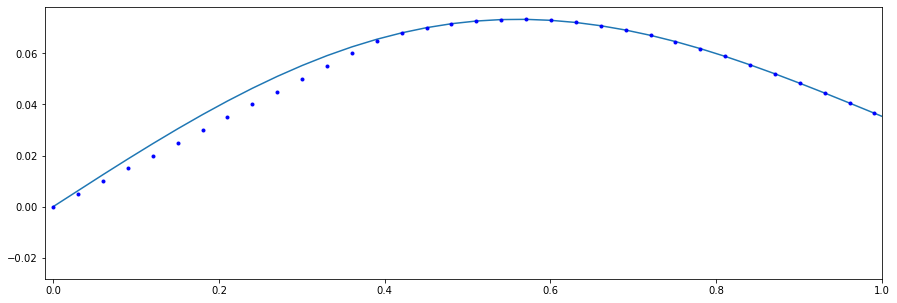

In [1018]:
def constrain(diff):
    max_diff = 0.005
    return obj.restrict_output(diff,0,max_diff) + obj.restrict_output(diff,-max_diff,0)-max_diff

# def restrict_diff(heights):
#     diff = heights[1:] - heights[:-1]
#     constrained = constrain(diff)
#     return t.concat([heights[[0]],constrained])

def restrict_diff(heights):
    out = t.zeros(heights.shape[0])
    out[0] = heights[0]
    for i in range(heights.shape[0]-1):
        diff = heights[i+1] - out[i]
        out[i+1] = out[i] + constrain(diff)
    return out

fig, ax = plt.subplots(figsize=(15,5))
x = t.linspace(0,30,1000)

rand = good#t.rand((15,1))*4
# good = rand.clone()
def f(x):
    return t.sin(rand*x).mean(0)*0.1

# tmp = t.cumsum(restrict_diff(f(x)),0)
ax.plot(x,f(x))
ax.plot(x,restrict_diff(f(x)),'b.')
ax.set_xlim(-0.01,1)


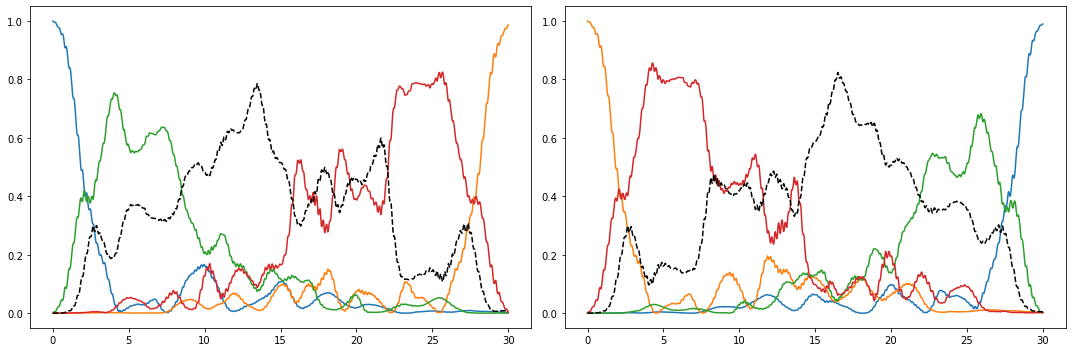

In [1422]:
fig, ax = plt.subplots(figsize=(15,5),ncols=2)
for i in range(2):
    occ = obj.get_occupancy([_ for _ in range(4)],i).detach()
    
    ax[i].plot(obj.times,occ[:-1].T)
    ax[i].plot(obj.times,occ[-1],'k--')
fig.tight_layout()

In [1423]:
U = obj()

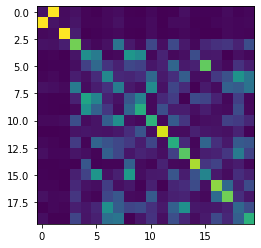

In [1424]:
plt.imshow(U.abs().detach())

In [811]:
# t.save(h,os.path.join(obj.params_dict['exp_path'],"19_09_1400_pulse.pt"))

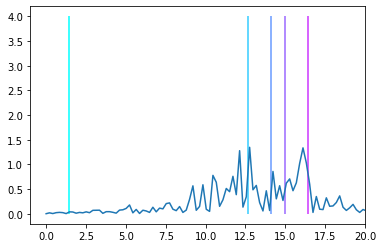

In [1425]:
pulse = obj.get_control().detach().clone()
eigvals = obj.H0_term[500].real.diagonal()
energies = [eigvals[3]-eigvals[2],
            eigvals[2]-eigvals[1],
            eigvals[3]-eigvals[1],
            eigvals[2]-eigvals[0],
            eigvals[3]-eigvals[0]]


fft = t.fft.rfft(pulse)
fig, ax = plt.subplots()
ax.plot(t.linspace(0,t.pi/obj.dt,obj.NTrot//2+1),fft.abs())
ax.set_xlim(-1,20)
for i,E in enumerate(energies):
    ax.vlines(E,0,4,colors=(i/len(energies),1-i/len(energies),1))

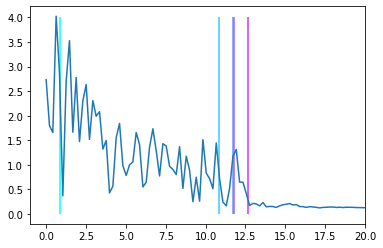

In [530]:
pulse = obj.get_control().detach().clone()
eigvals = obj.H0_term[0].real.diagonal()
energies = [eigvals[3]-eigvals[2],
            eigvals[2]-eigvals[1],
            eigvals[3]-eigvals[1],
            eigvals[2]-eigvals[0],
            eigvals[3]-eigvals[0]]


fft = t.fft.rfft(pulse)
fig, ax = plt.subplots()
ax.plot(t.linspace(0,t.pi/obj.dt,obj.NTrot//2+1),fft.abs())
ax.set_xlim(-1,20)
for i,E in enumerate(energies):
    ax.vlines(E,0,4,colors=(i/len(energies),1-i/len(energies),1))

In [431]:
thetas = t.linspace(0,2*t.pi,100).cfloat()
def z(t1,t2):
    return t.exp(1j*0.5*(t1-t2)) + 1/9*t.exp(1j*3/2*(t1-t2)) + 1/3*(t.exp(1j*(3/2*t1 - 0.5*t2)) + t.exp(1j*(t1/2-3/2*t2)))

diff = t.zeros(100,100).cfloat()
for i,t1 in enumerate(thetas):
    for j,t2 in enumerate(thetas):
        diff[i,j] = z(t1,t2)

tensor(0.2902+1.2968j)

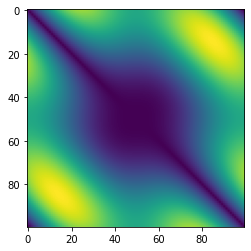

In [438]:
plt.imshow(diff.imag.abs())
diff[80,20]